In [25]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import scipy.spatial.distance as dist
from matplotlib.backends.backend_pdf import PdfPages
from navground import sim, core
import gudhi
from navground.sim.ui.video import display_video_from_run, record_video_from_run
from IPython.display import Image
from fpdf import FPDF
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp, ttest_ind
# import created library for experiments.
import importlib.util
from pathlib import Path
ruta_archivo = Path("..") / "functions.py"
spec = importlib.util.spec_from_file_location("functions", ruta_archivo)
fu = importlib.util.module_from_spec(spec)
spec.loader.exec_module(fu)

# We define the simulations to analyse

In [2]:
yaml = """
steps: 1000
time_step: 0.1
record_collisions: true
record_pose: true
record_deadlocks: true
record_safety_violation: true
record_efficacy: true
runs: 100
run_index: 0
scenario:
  type: Cross
  agent_margin: 0.1
  side: 4
  target_margin: 0.1
  tolerance: 0.5
  groups:
    -
      type: thymio
      number: 20
      radius: 0.08
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: 0.166
      behavior:
        type: HL
        optimal_speed: 0.12
        horizon: 5.0
        tau:
          sampler: uniform
          from: 0.0
          to: 1.0
          once: true
        eta:
          sampler: uniform
          from: 0.0
          to: 1.0
          once: true
        safety_margin:
          sampler: uniform
          from: 0.0
          to: 0.5
          once: true
      state_estimation:
        type: Bounded
        range_of_view: 5.0
"""

exp = sim.load_experiment(yaml)
exp.run(number_of_threads=12)
print("Duration: ", exp.duration)
print("Experiment path: ", exp.path)


Property name range_of_view is deprecated for Bounded, use range instead


Duration:  0:00:04.280848
Experiment path:  None


## Extract data from the simulations

We count the number of simulations with collisions/deadlocks

In [3]:
data = fu.extract_data(exp,"HL")

print(pd.value_counts(data["safe"]))
print(pd.value_counts(data["fluid"]))

data.head()

safe
1    90
0    10
Name: count, dtype: int64
fluid
0    52
1    48
Name: count, dtype: int64


seeds  safety_margin       eta       tau  deadlocks  collisions  \
0      0       0.357595  0.548814  0.592845         18           0   
1      1       0.360162  0.417022  0.997185         19           0   
2      2       0.012963  0.435995  0.185082          0           5   
3      3       0.354074  0.550798  0.070725         19           0   
4      4       0.273616  0.967030  0.900621          0           0   

   barrier_angle  efficacy  safe  fluid  ok  
0       1.570796  0.291751     1      0   0  
1       1.570796  0.345384     1      0   0  
2       1.570796  0.887340     0      1   0  
3       1.570796  0.378685     1      0   0  
4       1.570796  0.607004     1      1   1

## Visualizar simulacion

In [12]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

def linear_map(a, b, cmap):
    c = cmx.ScalarMappable(norm=colors.Normalize(vmin=a, vmax=b), cmap=cmap)  
    def f(v):
        r, g, b, _ = c.to_rgba(v)
        return f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}"
    return f


fill_map = linear_map(0.0, 1.0, cmap=cmx.RdYlGn)

def f(entity): #display collisions and deadlocks in the simulation
    return {'fill': 'red' if entity.has_been_in_collision_since(run.world.time - 0.5) 
        else 'blue' if entity.has_been_stuck_since(run.world.time - 0.5) 
        else 'lightgreen'}


i = 0
run = exp.runs[i]
display_video_from_run(run, factor=3.0,
            bounds=(np.array([-4/1.5,-4/1.5]),np.array([4/1.5,4/1.5])), 
             decorate=f, width=600,)


## Exploratory analysis of the trajectory time series:

We start by analysing the general characteristics of these time series based on the persistent entropy calculated by the Lower Star filtration method on the 3 time series corresponding to the trajectory of the robots.

A trajectory will be positive if it has no negative event and positive if it has any of them (collision or deadlock) at any time of the trajectory (simulation).

In [9]:
entropyX=[]
entropyY=[]
entropyAngle=[]
collision=[]
deadlock=[]
for i in tqdm(range(100),desc="Simulations"):
    run = exp.runs[i]
    trajectories = run.poses.copy()
    trajectories[:,:,2] = fu.normangle(trajectories[:,:,2])
    for robot in range(20):
        robot_collisions = [timestep for timestep, r1, r2 in run.collisions if r1 == robot or r2 == robot]
        deadlock_time = run.deadlocks[robot]
        collision.append(1 if len(robot_collisions) > 0 else 0) # 1 if robot collide at any time of the simulation
        deadlock.append(1 if deadlock_time > 0 else 0) #1 if robot enter in a deadlock state during the simulation
        
        for feature in range(trajectories.shape[2]):
            x=np.arange(0,trajectories.shape[0])
            y=trajectories[:,robot,feature]
            dgms = fu.calculatePersistenceDiagrams_LowerStar(x,y)
            dgm = fu.obtainDiagramDimension(dgms,0)
            dgmL = fu.limitDiagramLowerStar(dgm,max(y))
            entropy = fu.computePersistenceEntropy(dgmL)
            if feature == 0:
                entropyX.append(entropy)
            elif feature == 1:
                entropyY.append(entropy)
            elif feature == 2:
                entropyAngle.append(entropy)


df = pd.DataFrame(zip(entropyX,entropyY,entropyAngle,collision,deadlock),columns = ["entropyX","entropyY","entropyAngle","collision","deadlock"])
df["safe"] = ((df['collision'] > 0) | (df['deadlock'] > 0)).astype(int) # 0 safe, 1 unsafe becaus collisions or deadlocks

Simulations: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.44it/s]


In [17]:
df.describe()

entropyX     entropyY  entropyAngle    collision     deadlock  \
count  2000.000000  2000.000000   2000.000000  2000.000000  2000.000000   
mean      0.646677     0.647099      2.074452     0.038500     0.386500   
std       0.355536     0.347296      0.520331     0.192448     0.487069   
min      -0.000000    -0.000000     -0.000000     0.000000     0.000000   
25%       0.460950     0.477100      1.809725     0.000000     0.000000   
50%       0.681500     0.680550      2.218400     0.000000     0.000000   
75%       0.899450     0.885700      2.434800     0.000000     1.000000   
max       1.521300     1.531300      3.039000     1.000000     1.000000   

              safe  
count  2000.000000  
mean      0.425000  
std       0.494467  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [11]:
correlation_matrix = df.corr()
print(correlation_matrix)

              entropyX  entropyY  entropyAngle  collision  deadlock      safe
entropyX      1.000000  0.394786      0.579272   0.132279 -0.642095 -0.581006
entropyY      0.394786  1.000000      0.719075   0.107839 -0.645879 -0.594245
entropyAngle  0.579272  0.719075      1.000000   0.105310 -0.704252 -0.652729
collision     0.132279  0.107839      0.105310   1.000000 -0.158827  0.232753
deadlock     -0.642095 -0.645879     -0.704252  -0.158827  1.000000  0.923224
safe         -0.581006 -0.594245     -0.652729   0.232753  0.923224  1.000000


Collisions

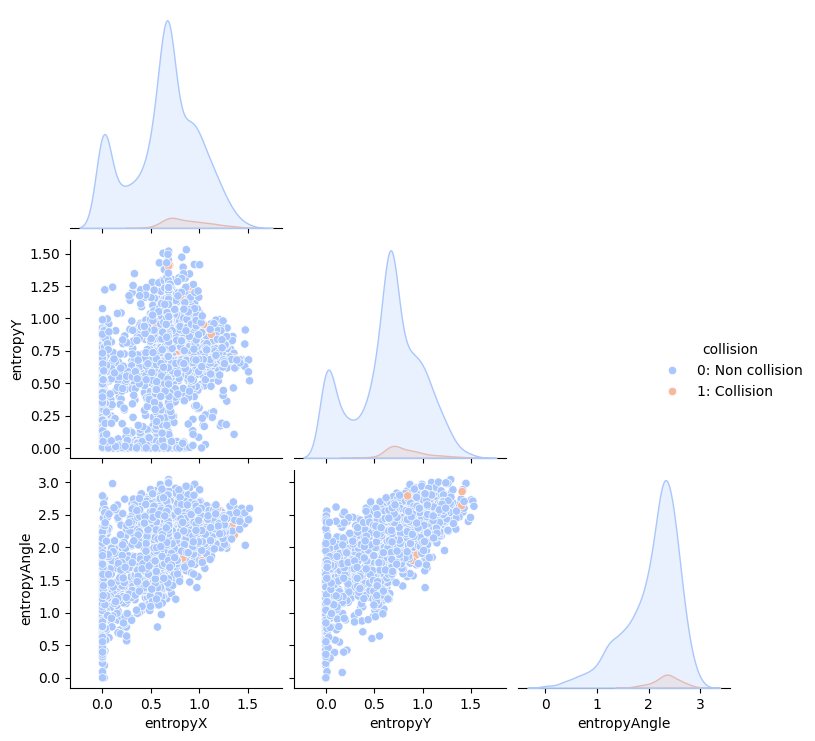

In [16]:
pairplot = sns.pairplot(df, vars=["entropyX","entropyY","entropyAngle"], hue='collision', palette='coolwarm',corner=True)
new_labels = ['0: Non collision', '1: Collision']  
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

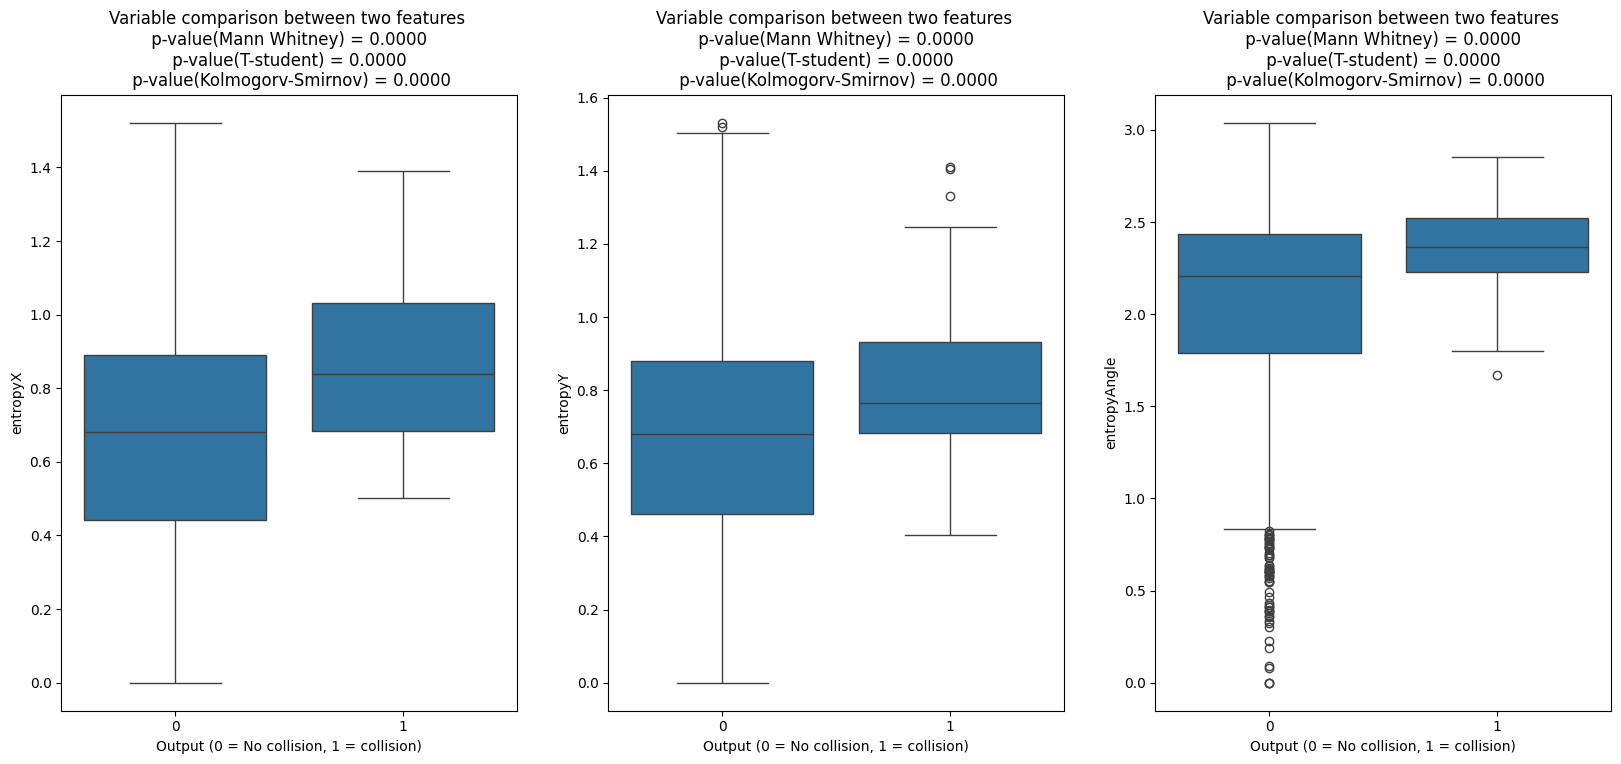

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(["entropyX","entropyY","entropyAngle"]):
    Cvalues = df[df["collision"] == 1][i].values
    NCvalues = df[df["collision"] == 0][i].values
    stat1, p_value1 = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    stat2, p_value2 = ttest_ind(Cvalues, NCvalues,equal_var=True)
    stat3, p_value3 = ks_2samp(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='collision', y=i, data=df)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value1:.4f} \n p-value(T-student) = {p_value2:.4f} \n p-value(Kolmogorv-Smirnov) = {p_value3:.4f}')
    plt.xlabel("Output (0 = No collision, 1 = collision)")
    plt.ylabel(i)

plt.show()

Deadlock

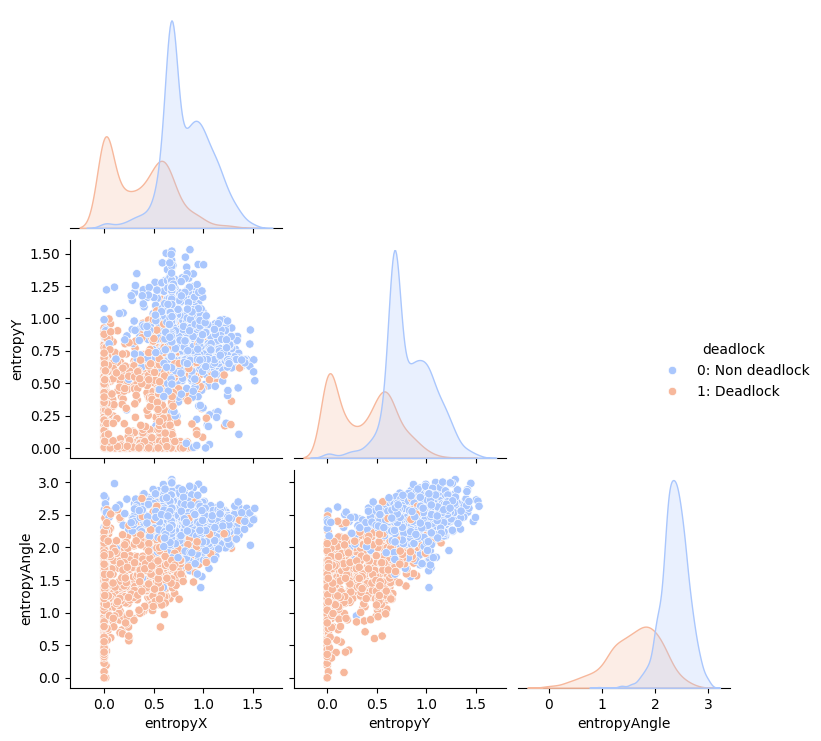

In [19]:
pairplot = sns.pairplot(df, vars=["entropyX","entropyY","entropyAngle"], hue='deadlock', palette='coolwarm',corner=True)
new_labels = ['0: Non deadlock', '1: Deadlock']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

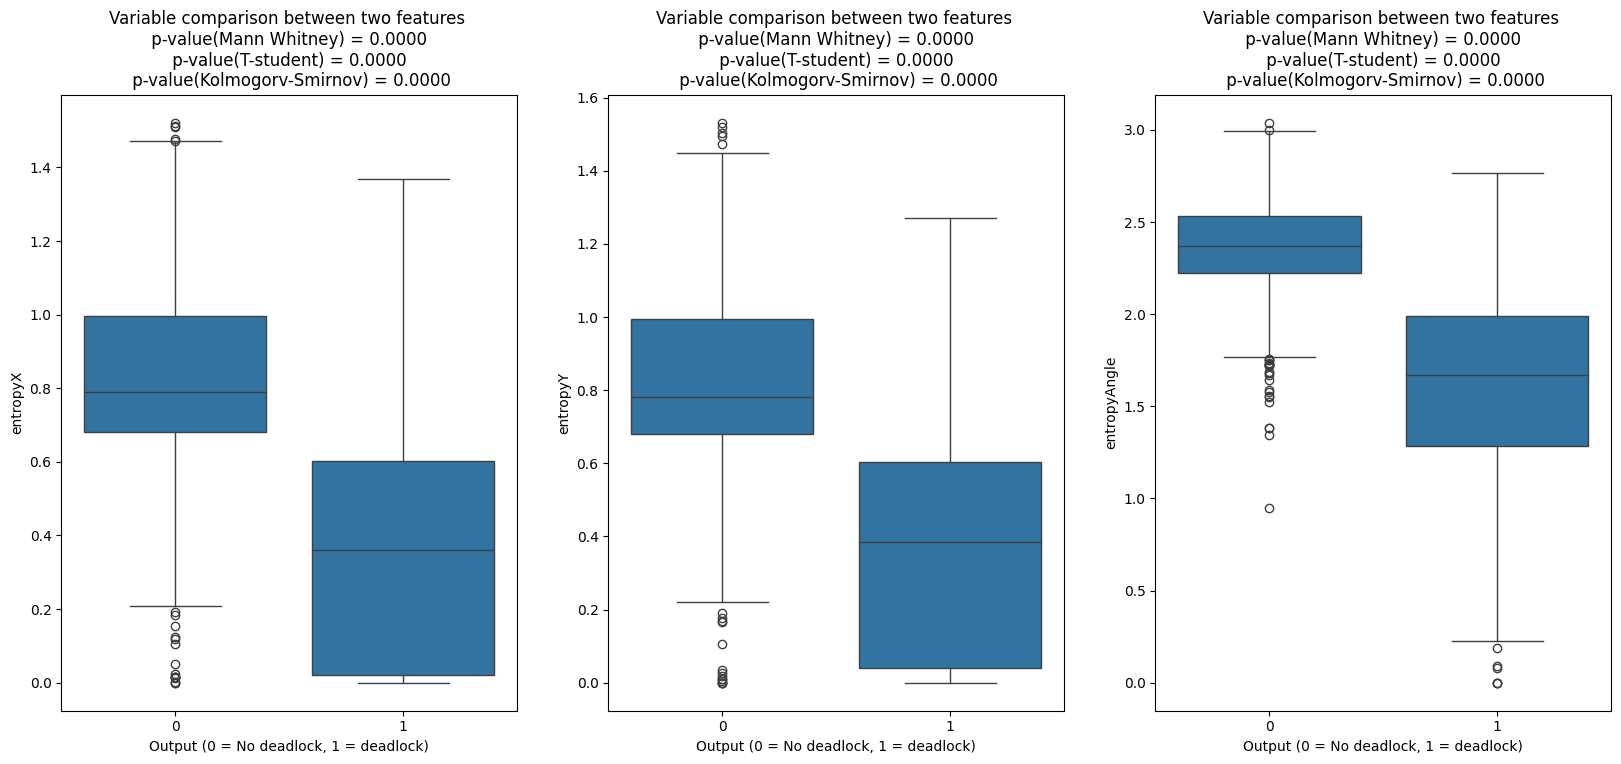

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(["entropyX","entropyY","entropyAngle"]):
    Cvalues = df[df["deadlock"] == 1][i].values
    NCvalues = df[df["deadlock"] == 0][i].values
    stat1, p_value1 = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    stat2, p_value2 = ttest_ind(Cvalues, NCvalues,equal_var=True)
    stat3, p_value3 = ks_2samp(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='deadlock', y=i, data=df)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value1:.4f} \n p-value(T-student) = {p_value2:.4f} \n p-value(Kolmogorv-Smirnov) = {p_value3:.4f}')
    plt.xlabel("Output (0 = No deadlock, 1 = deadlock)")
    plt.ylabel(i)

plt.show()

It appears that the entropy of the trajectories can be used to identify whether a robot is going to present a deadlock case in the trajectory.

Safe sim

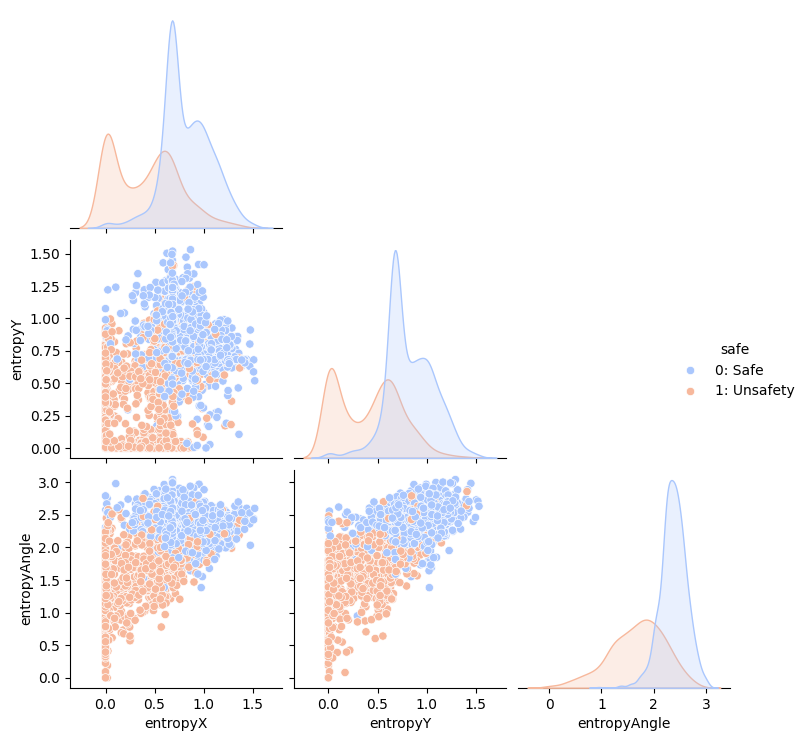

In [20]:
pairplot = sns.pairplot(df, vars=["entropyX","entropyY","entropyAngle"], hue='safe', palette='coolwarm',corner=True)
new_labels = ['0: Safe', '1: Unsafety']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

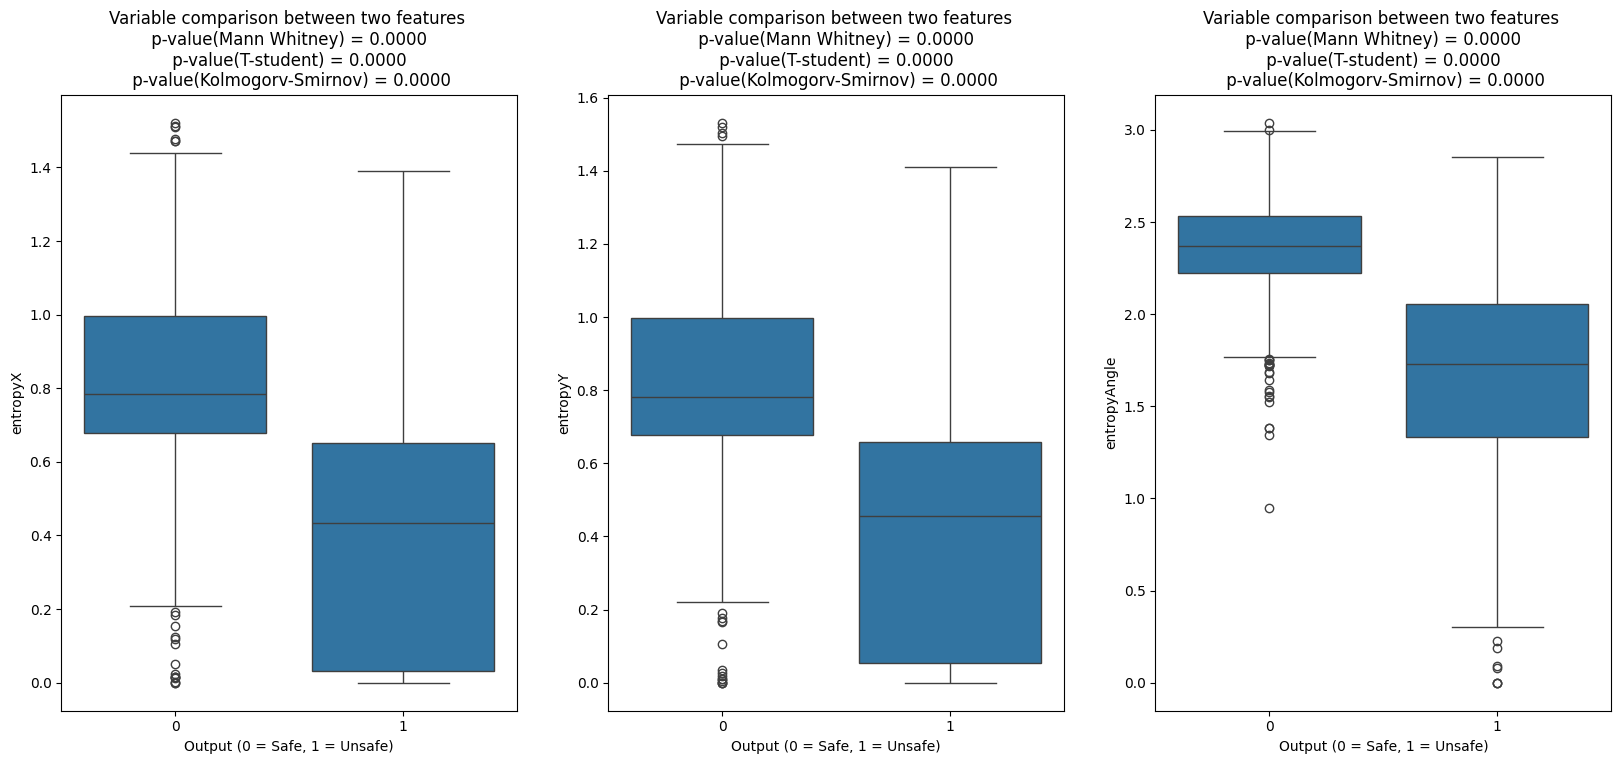

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(["entropyX","entropyY","entropyAngle"]):
    Cvalues = df[df["safe"] == 1][i].values
    NCvalues = df[df["safe"] == 0][i].values
    stat1, p_value1 = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    stat2, p_value2 = ttest_ind(Cvalues, NCvalues,equal_var=True)
    stat3, p_value3 = ks_2samp(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='safe', y=i, data=df)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value1:.4f} \n p-value(T-student) = {p_value2:.4f} \n p-value(Kolmogorv-Smirnov) = {p_value3:.4f}')
    plt.xlabel("Output (0 = Safe, 1 = Unsafe)")
    plt.ylabel(i)

plt.show()

# Analysis by time windows prior to the negative event.

For each series with a negative event, extract a fixed time window before the instant at which the event occurs, e.g. 50 or 100 points prior. These time windows will provide you with ‘sub-series’ that capture the pre-event behaviour.

Label these sub-series as ‘pre-negative event’ and compare this window with equivalent windows in series without negative events.

In [39]:
df.describe()

entropyX      entropyY  entropyAngle     collision      deadlock  \
count  37420.000000  37420.000000  37420.000000  37420.000000  37420.000000   
mean       0.014020      0.013914      0.255844      0.003287      0.010957   
std        0.044231      0.043882      0.250722      0.057239      0.104101   
min       -0.000000     -0.000000     -0.000000      0.000000      0.000000   
25%       -0.000000     -0.000000     -0.000000      0.000000      0.000000   
50%       -0.000000     -0.000000      0.203100      0.000000      0.000000   
75%        0.000000      0.000000      0.433300      0.000000      0.000000   
max        0.388600      0.395000      1.756800      1.000000      1.000000   

               safe  
count  37420.000000  
mean       0.014244  
std        0.118496  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [37]:
entropyX=[]
entropyY=[]
entropyAngle=[]
collision=[]
deadlock=[]
window_size = 50
for i in tqdm(range(100),desc="Simulations"):
    run = exp.runs[i]
    trajectories = run.poses.copy()
    trajectories[:,:,2] = fu.normangle(trajectories[:,:,2])
    for robot in range(20):
        robot_collisions = [timestep for timestep, r1, r2 in run.collisions if r1 == robot or r2 == robot]
        deadlock_time = run.deadlocks[robot]
        # collision.append(1 if len(robot_collisions) > 0 else 0) 
        # deadlock.append(1 if deadlock_time > 0 else 0) 
        for time in range(0, trajectories.shape[0] - 100 + 1, 50):
            collision.append(1 if any((time+window_size) <= x <= (time+window_size+window_size) for x in robot_collisions) else 0) # 1 si el robot colisiona en algun instante.
            deadlock.append(1 if (time+window_size) <= deadlock_time <= (time+window_size+window_size) else 0) #1 si el robot deadlock en algun instate
            for feature in range(trajectories.shape[2]):
                x=np.arange(0,window_size)
                y=trajectories[time:time+window_size,robot,feature]
                dgms = fu.calculatePersistenceDiagrams_LowerStar(x,y)
                dgm = fu.obtainDiagramDimension(dgms,0)
                dgmL = fu.limitDiagramLowerStar(dgm,max(y))
                entropy = fu.computePersistenceEntropy(dgmL)
                if feature == 0:
                    entropyX.append(entropy)
                elif feature == 1:
                    entropyY.append(entropy)
                elif feature == 2:
                    entropyAngle.append(entropy)


df = pd.DataFrame(zip(entropyX,entropyY,entropyAngle,collision,deadlock),columns = ["entropyX","entropyY","entropyAngle","collision","deadlock"])
df["safe"] = ((df['collision'] > 0) | (df['deadlock'] > 0)).astype(int) # 0 safe, 1 unsafe becaus collisions or deadlocks

Simulations: 100%|████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


In [41]:
df.describe()

entropyX      entropyY  entropyAngle     collision      deadlock  \
count  37420.000000  37420.000000  37420.000000  37420.000000  37420.000000   
mean       0.014020      0.013914      0.255844      0.003287      0.010957   
std        0.044231      0.043882      0.250722      0.057239      0.104101   
min       -0.000000     -0.000000     -0.000000      0.000000      0.000000   
25%       -0.000000     -0.000000     -0.000000      0.000000      0.000000   
50%       -0.000000     -0.000000      0.203100      0.000000      0.000000   
75%        0.000000      0.000000      0.433300      0.000000      0.000000   
max        0.388600      0.395000      1.756800      1.000000      1.000000   

               safe  
count  37420.000000  
mean       0.014244  
std        0.118496  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [38]:
correlation_matrix = df.corr()
print(correlation_matrix)

              entropyX  entropyY  entropyAngle  collision  deadlock      safe
entropyX      1.000000  0.021653      0.105846   0.007341  0.011864  0.013968
entropyY      0.021653  1.000000      0.201467   0.014396  0.012515  0.017949
entropyAngle  0.105846  0.201467      1.000000   0.003188  0.066664  0.060105
collision     0.007341  0.014396      0.003188   1.000000 -0.006044  0.477737
deadlock      0.011864  0.012515      0.066664  -0.006044  1.000000  0.875599
safe          0.013968  0.017949      0.060105   0.477737  0.875599  1.000000


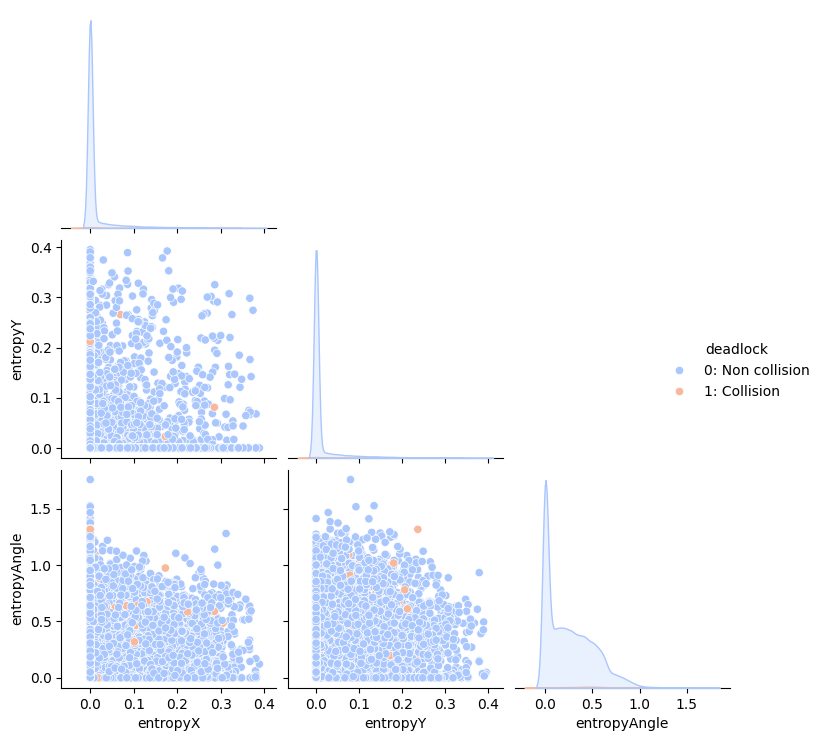

In [42]:
pairplot = sns.pairplot(df, vars=["entropyX","entropyY","entropyAngle"], hue='deadlock', palette='coolwarm',corner=True)
new_labels = ['0: Non collision', '1: Collision']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

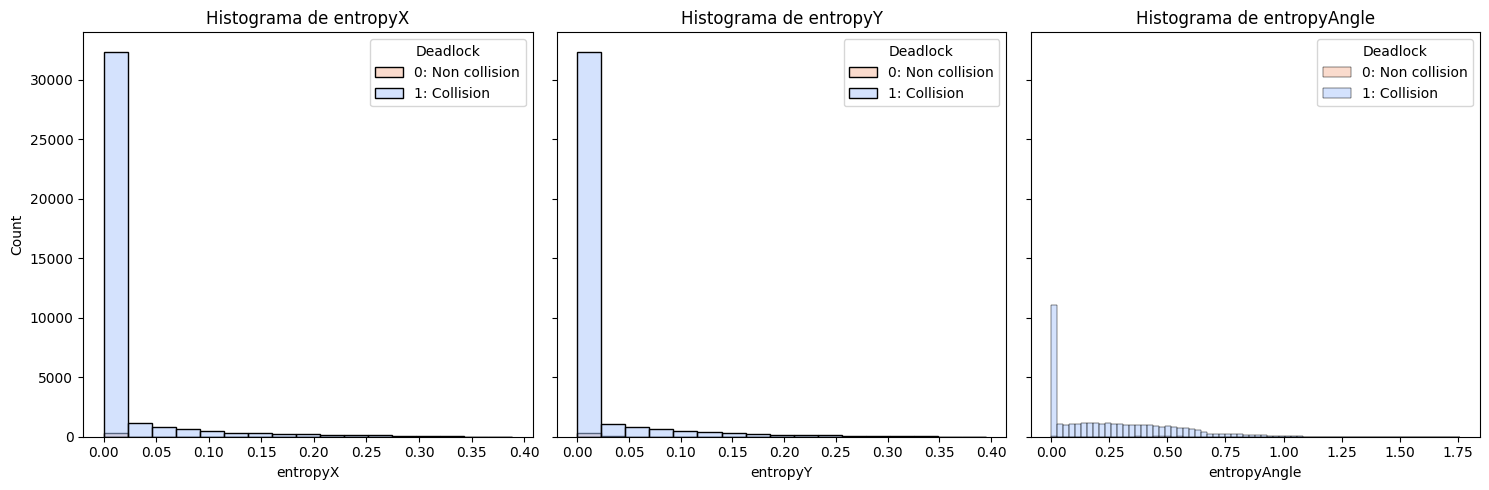

In [47]:
new_labels = ['0: Non collision', '1: Collision']  

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

variables = ["entropyX", "entropyY", "entropyAngle"]

for i, var in enumerate(variables):
    sns.histplot(data=df, x=var, hue='deadlock', palette='coolwarm', ax=axes[i])
    axes[i].legend(title='Deadlock', labels=new_labels)
    axes[i].set_title(f'{var} Histogram')

plt.tight_layout()
plt.show()

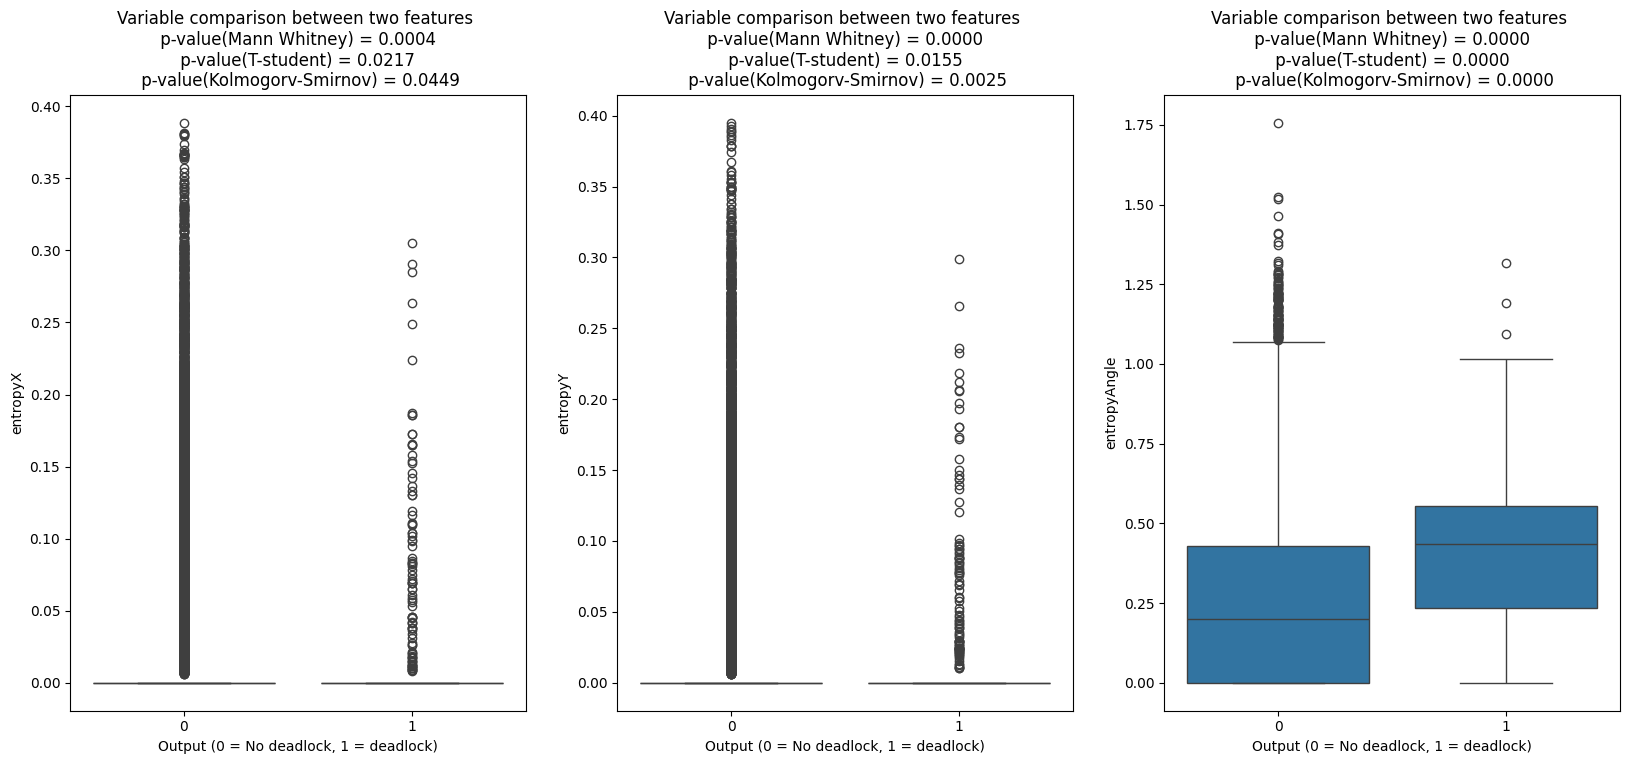

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(["entropyX","entropyY","entropyAngle"]):
    Cvalues = df[df["deadlock"] == 1][i].values
    NCvalues = df[df["deadlock"] == 0][i].values
    stat1, p_value1 = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    stat2, p_value2 = ttest_ind(Cvalues, NCvalues,equal_var=True)
    stat3, p_value3 = ks_2samp(Cvalues, NCvalues, alternative="two-sided")
    plt.sca(axes[num])
    sns.boxplot(x='deadlock', y=i, data=df)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value1:.4f} \n p-value(T-student) = {p_value2:.4f} \n p-value(Kolmogorv-Smirnov) = {p_value3:.4f}')
    plt.xlabel("Output (0 = No deadlock, 1 = deadlock)")
    plt.ylabel(i)

plt.show()

# PDF visualisation of trajectories

In [17]:
pdf_filename = "CollisionsTrayectories.pdf"

pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

for i in tqdm(range(5),desc="Simulations"):
    # Añadir una nueva página para cada simulacion
    run = exp.runs[i]
    pdf.add_page()
    pdf.set_font("Arial", size=16, style='B')
    pdf.cell(200, 10, f"Simulación número {i+1}", ln=True, align="C")

    trajectories = run.poses.copy()
    trajectories[:,:,2] = fu.normangle(trajectories[:,:,2])
    for robot in range(20):
        pdf.cell(200, 10, f"Robot {robot}", ln=True, align="C")
        robot_collisions = [timestep for timestep, r1, r2 in run.collisions if r1 == robot or r2 == robot]
        deadlock_time = run.deadlocks[robot]
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 16))
        axes = axes.flatten()
        for feature in range(trajectories.shape[2]):
            if feature == 0:
                label = "Coordinate x"
            elif feature == 1:
                label = "Coordinate y"
            else:
                label = "Angle"
            plt.sca(axes[feature])
            x=np.arange(0,trajectories.shape[0])
            y=trajectories[:,robot,feature]
            dgms = fu.calculatePersistenceDiagrams_LowerStar(x,y)
            dgm = fu.obtainDiagramDimension(dgms,0)
            dgmL = fu.limitDiagramLowerStar(dgm,max(y))
            entropy = fu.computePersistenceEntropy(dgmL)
            plt.plot(x, y,linestyle='-', label=label)
            for timestep in robot_collisions:
                plt.axvline(x=timestep, color='blue', linestyle='-', alpha=0.5)
            if deadlock_time > 0:
                plt.axvline(x=deadlock_time, color='red', linestyle='-', alpha=0.5)
            plt.title(f"Robot {robot}, {label}, \n Entropia persistente: {entropy}")
            plt.xlabel("Time")
            plt.ylabel(label)
            plt.grid(True)

        # Guardar la imagen en un archivo temporal
        image_filename = f"images/simulation_{i}_robot_{robot}.png"
        plt.savefig(image_filename, bbox_inches='tight')
        plt.close(fig)  # Cerrar la figura para liberar memoria
    
        # Añadir la imagen al PDF
        pdf.image(image_filename, w=175,h=65)  # Ajusta la posición y tamaño de la imagen
        pdf.ln(5)  # Añadir espacio entre la imagen y el siguiente contenido

# Guardar el PDF
pdf.output(pdf_filename)

print(f"PDF succesfully created {pdf_filename}")


Simulations: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.22s/it]


PDF creado exitosamente: TrayectoriasColisiones.pdf
